In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.neighbors import KNeighborsClassifier
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/learn-together/test.csv
/kaggle/input/learn-together/train.csv
/kaggle/input/learn-together/sample_submission.csv


### Forests- division

In [2]:
data = pd.read_csv("/kaggle/input/learn-together/train.csv", sep=",")
X = data.drop(["Cover_Type"], axis=1)
y = pd.DataFrame(data, columns=["Cover_Type"])
test = pd.read_csv("/kaggle/input/learn-together/test.csv", sep=",")

In [3]:
X.drop(['Id', 'Soil_Type7', 'Soil_Type15'], axis=1, inplace=True)
test_dr = test.drop(['Soil_Type7', 'Soil_Type15'], axis=1)

In [4]:
print(X.loc[X['Wilderness_Area1'] == True, 'Wilderness_Area1'].count())
print(X.loc[X['Wilderness_Area2'] == True, 'Wilderness_Area2'].count())
print(X.loc[X['Wilderness_Area3'] == True, 'Wilderness_Area3'].count())
print(X.loc[X['Wilderness_Area4'] == True, 'Wilderness_Area4'].count())

3597
499
6349
4675


In [5]:
data.loc[data['Cover_Type'] == 3, 'Cover_Type'].count()

2160

In [6]:
data.groupby(['Cover_Type'])['Cover_Type'].count()

Cover_Type
1    2160
2    2160
3    2160
4    2160
5    2160
6    2160
7    2160
Name: Cover_Type, dtype: int64

In [7]:
WA1ind = data.loc[data['Wilderness_Area1'] == 1].index
WA2ind = data.loc[data['Wilderness_Area2'] == 1].index
WA3ind = data.loc[data['Wilderness_Area3'] == 1].index
WA4ind = data.loc[data['Wilderness_Area4'] == 1].index

In [8]:
wa1 = data.loc[WA1ind].groupby(['Cover_Type'])['Cover_Type'].count()
wa2 = data.loc[WA2ind].groupby(['Cover_Type'])['Cover_Type'].count()
wa3 = data.loc[WA3ind].groupby(['Cover_Type'])['Cover_Type'].count()
wa4 = data.loc[WA4ind].groupby(['Cover_Type'])['Cover_Type'].count()

In [9]:
print(wa1)
print(wa2)
print(wa3)
print(wa4)

Cover_Type
1    1062
2    1134
5     856
7     545
Name: Cover_Type, dtype: int64
Cover_Type
1    181
2     66
7    252
Name: Cover_Type, dtype: int64
Cover_Type
1     917
2     940
3     863
5    1304
6     962
7    1363
Name: Cover_Type, dtype: int64
Cover_Type
2      20
3    1297
4    2160
6    1198
Name: Cover_Type, dtype: int64


Text(0.5, 1.0, 'Wilderness_Area4')

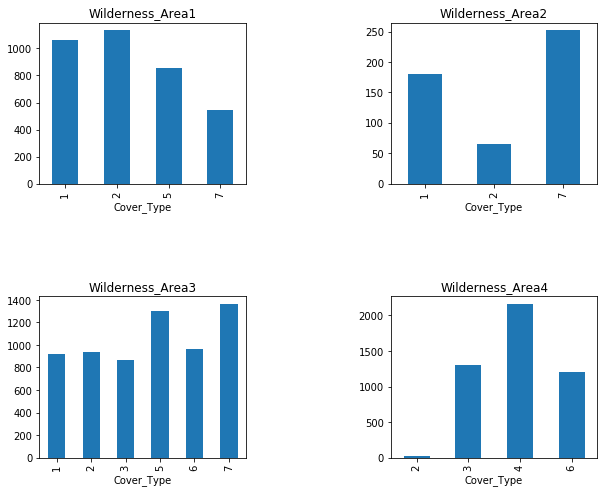

In [10]:
fig, ax = plt.subplots(nrows=2, ncols=2)
ax1, ax2, ax3, ax4 = ax.flatten()

fig.set_size_inches(10, 8)
fig.subplots_adjust(wspace=0.7, hspace=0.7)

wa1.plot(kind="bar", ax = ax1)
wa2.plot(kind="bar", ax = ax2)
wa3.plot(kind="bar", ax = ax3)
wa4.plot(kind="bar", ax = ax4)
ax1.set_title("Wilderness_Area1")
ax2.set_title("Wilderness_Area2")
ax3.set_title("Wilderness_Area3")
ax4.set_title("Wilderness_Area4")

In [11]:
forest_1 = X.loc[X['Wilderness_Area1'] == 1].copy()
test_forest_1 = test_dr.loc[test_dr['Wilderness_Area1'] == 1].copy()
y_forest_1 = y.iloc[WA1ind].copy()
forest_2 = X.loc[X['Wilderness_Area2'] == 1].copy()
test_forest_2 = test_dr.loc[test_dr['Wilderness_Area2'] == 1].copy()
y_forest_2 = y.iloc[WA2ind].copy()
forest_3 = X.loc[X['Wilderness_Area3'] == 1].copy()
test_forest_3 = test_dr.loc[test_dr['Wilderness_Area3'] == 1].copy()
y_forest_3 = y.iloc[WA3ind].copy()
forest_4 = X.loc[X['Wilderness_Area4'] == 1].copy()
test_forest_4 = test_dr.loc[test_dr['Wilderness_Area4'] == 1].copy()
y_forest_4 = y.iloc[WA4ind].copy()

In [12]:
test_forest_4.nunique()

Id                                    32293
Elevation                               773
Aspect                                  361
Slope                                    51
Horizontal_Distance_To_Hydrology        167
Vertical_Distance_To_Hydrology          406
Horizontal_Distance_To_Roadways         837
Hillshade_9am                           196
Hillshade_Noon                          153
Hillshade_3pm                           251
Horizontal_Distance_To_Fire_Points     1016
Wilderness_Area1                          1
Wilderness_Area2                          1
Wilderness_Area3                          1
Wilderness_Area4                          1
Soil_Type1                                2
Soil_Type2                                2
Soil_Type3                                2
Soil_Type4                                2
Soil_Type5                                2
Soil_Type6                                2
Soil_Type8                                1
Soil_Type9                      

In [13]:
def feature_remover(sc_data):
    drop_list = []
    for ind in range(0, sc_data.shape[1]):
        if sc_data.iloc[:,ind].nunique() == 1:
            #print("Drop {}".format(sc_data.keys()[ind]))
            drop_list.append(ind)
    sc_data.drop(sc_data.keys()[drop_list], axis=1, inplace = True)
    return sc_data

In [14]:
all_forest_list = [forest_1, forest_2, forest_3, forest_4, test_forest_1, test_forest_2, test_forest_3, test_forest_4]
for fr in all_forest_list:
    fr = feature_remover(fr)
    print(fr.nunique())

Elevation                              905
Aspect                                 355
Slope                                   47
Horizontal_Distance_To_Hydrology       237
Vertical_Distance_To_Hydrology         305
Horizontal_Distance_To_Roadways       2109
Hillshade_9am                          132
Hillshade_Noon                         123
Hillshade_3pm                          219
Horizontal_Distance_To_Fire_Points    2020
Soil_Type8                               2
Soil_Type9                               2
Soil_Type12                              2
Soil_Type16                              2
Soil_Type18                              2
Soil_Type19                              2
Soil_Type20                              2
Soil_Type22                              2
Soil_Type23                              2
Soil_Type24                              2
Soil_Type29                              2
Soil_Type30                              2
Soil_Type35                              2
Soil_Type37

In [15]:
test_forest_2.drop(["Soil_Type16", "Soil_Type18"], axis=1, inplace = True)

In [16]:
res_1 = test_forest_1[['Id']].copy()
res_2 = test_forest_2[['Id']].copy()
res_3 = test_forest_3[['Id']].copy()
res_4 = test_forest_4[['Id']].copy()
res_1 = res_1.reset_index(drop=True)
res_2 = res_2.reset_index(drop=True)
res_3 = res_3.reset_index(drop=True)
res_4 = res_4.reset_index(drop=True)

In [17]:
res_3

,Id
0,205499
1,205770
2,206037
3,206038
4,206309
5,206310
6,206311
7,206577
8,206578
9,206579


In [18]:
test_forest_1.drop(["Id"], axis=1, inplace = True)
test_forest_2.drop(["Id"], axis=1, inplace = True)
test_forest_3.drop(["Id"], axis=1, inplace = True)
test_forest_4.drop(["Id"], axis=1, inplace = True)

In [19]:
forest_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3597 entries, 0 to 14591
Data columns (total 27 columns):
Elevation                             3597 non-null int64
Aspect                                3597 non-null int64
Slope                                 3597 non-null int64
Horizontal_Distance_To_Hydrology      3597 non-null int64
Vertical_Distance_To_Hydrology        3597 non-null int64
Horizontal_Distance_To_Roadways       3597 non-null int64
Hillshade_9am                         3597 non-null int64
Hillshade_Noon                        3597 non-null int64
Hillshade_3pm                         3597 non-null int64
Horizontal_Distance_To_Fire_Points    3597 non-null int64
Soil_Type8                            3597 non-null int64
Soil_Type9                            3597 non-null int64
Soil_Type12                           3597 non-null int64
Soil_Type16                           3597 non-null int64
Soil_Type18                           3597 non-null int64
Soil_Type19           

In [20]:
fr_1 = pd.concat([forest_1, y_forest_1], axis=1)
fr_2 = pd.concat([forest_2, y_forest_2], axis=1)
fr_3 = pd.concat([forest_3, y_forest_3], axis=1)
fr_4 = pd.concat([forest_4, y_forest_4], axis=1)
fr_1

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type23,Soil_Type24,Soil_Type29,Soil_Type30,Soil_Type35,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,1,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,1,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,1,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,1,0,0,0,0,0,0,5
5,2579,132,6,300,-15,67,230,237,140,6031,...,0,0,1,0,0,0,0,0,0,2
6,2606,45,7,270,5,633,222,225,138,6256,...,0,0,1,0,0,0,0,0,0,5
7,2605,49,4,234,7,573,222,230,144,6228,...,0,0,1,0,0,0,0,0,0,5
8,2617,45,9,240,56,666,223,221,133,6244,...,0,0,1,0,0,0,0,0,0,5
9,2612,59,10,247,11,636,228,219,124,6230,...,0,0,1,0,0,0,0,0,0,5


In [21]:
fr_1.corr()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type23,Soil_Type24,Soil_Type29,Soil_Type30,Soil_Type35,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
Elevation,1.000000,0.121128,-0.133357,0.218084,0.088839,0.440339,-0.150300,0.188238,0.219503,-0.012084,...,0.053298,-0.046818,-0.068041,-0.338974,0.160079,0.147705,0.333637,0.332844,0.310150,0.078877
Aspect,0.121128,1.000000,-0.100408,0.023068,-0.000957,0.280974,-0.567605,0.365322,0.570685,0.030331,...,0.063589,0.028808,0.023078,-0.085085,-0.012777,-0.078231,0.037584,0.026732,-0.013538,-0.126604
Slope,-0.133357,-0.100408,1.000000,0.026074,0.317701,-0.384351,0.072865,-0.783764,-0.632238,-0.196070,...,-0.234116,0.058107,0.001761,0.418119,-0.049784,0.051102,-0.103174,0.092365,0.019172,0.229576
Horizontal_Distance_To_Hydrology,0.218084,0.023068,0.026074,1.000000,0.585652,0.123034,-0.035255,0.047722,0.045457,0.049661,...,-0.147780,0.038934,0.111434,-0.075479,0.129387,-0.070611,-0.070994,0.039713,0.163801,-0.135377
Vertical_Distance_To_Hydrology,0.088839,-0.000957,0.317701,0.585652,1.000000,-0.093935,-0.009155,-0.224552,-0.165610,-0.086201,...,-0.176050,0.075968,0.024298,0.126408,0.138494,-0.057010,-0.086542,0.061617,0.167840,0.059048
Horizontal_Distance_To_Roadways,0.440339,0.280974,-0.384351,0.123034,-0.093935,1.000000,-0.336077,0.432934,0.511154,0.271153,...,0.093237,0.016723,0.116679,-0.346268,-0.002674,0.044577,0.114286,0.017047,0.035976,-0.260282
Hillshade_9am,-0.150300,-0.567605,0.072865,-0.035255,-0.009155,-0.336077,1.000000,-0.172839,-0.744639,-0.099060,...,-0.066868,-0.109660,-0.127259,0.297147,0.025660,-0.009460,-0.047967,-0.049405,0.028407,0.232027
Hillshade_Noon,0.188238,0.365322,-0.783764,0.047722,-0.224552,0.432934,-0.172839,1.000000,0.773781,0.149829,...,0.166320,-0.039705,0.011092,-0.305447,0.029576,-0.085535,0.073080,-0.051970,-0.018600,-0.220270
Hillshade_3pm,0.219503,0.570685,-0.632238,0.045457,-0.165610,0.511154,-0.744639,0.773781,1.000000,0.174331,...,0.168081,0.042511,0.094086,-0.428819,0.007966,-0.046766,0.088566,-0.010957,-0.034080,-0.306557
Horizontal_Distance_To_Fire_Points,-0.012084,0.030331,-0.196070,0.049661,-0.086201,0.271153,-0.099060,0.149829,0.174331,1.000000,...,-0.060204,0.070084,0.042260,-0.245421,-0.029478,0.008128,0.033374,0.006424,0.031600,-0.051368


In [22]:
fr_2.corr()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type25,Soil_Type29,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type35,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
Elevation,1.000000,-0.160299,0.085524,0.216650,0.344046,0.485863,-0.031456,-0.198072,-0.065779,-0.151740,...,-0.015504,-0.044224,0.031854,-0.153314,-0.072765,-0.007582,0.102246,0.187839,0.673312,0.756954
Aspect,-0.160299,1.000000,0.174088,-0.100049,-0.004627,-0.122092,-0.632124,0.165090,0.658852,-0.119557,...,-0.018049,-0.036283,-0.047591,-0.050371,0.057055,-0.084743,-0.217356,0.122966,-0.050383,-0.133490
Slope,0.085524,0.174088,1.000000,-0.096519,0.180559,0.050511,-0.373250,-0.519993,-0.021906,0.097404,...,0.096304,-0.049661,-0.086313,0.018970,0.267902,0.005690,-0.109486,0.380982,-0.199063,0.030639
Horizontal_Distance_To_Hydrology,0.216650,-0.100049,-0.096519,1.000000,0.526659,-0.214675,0.007924,0.038115,0.022564,-0.224831,...,-0.043907,0.011510,0.190651,-0.077160,0.149780,-0.138246,0.134002,-0.206223,0.162103,0.028636
Vertical_Distance_To_Hydrology,0.344046,-0.004627,0.180559,0.526659,1.000000,-0.052874,-0.209901,-0.149043,0.111763,-0.148855,...,-0.059613,-0.032905,0.203783,-0.072753,0.140798,-0.093533,-0.116323,-0.051184,0.322018,0.136072
Horizontal_Distance_To_Roadways,0.485863,-0.122092,0.050511,-0.214675,-0.052874,1.000000,0.056547,-0.174586,-0.131202,0.302724,...,-0.043988,-0.086065,0.036525,-0.087894,0.003094,0.204595,0.007286,0.236772,0.237838,0.314760
Hillshade_9am,-0.031456,-0.632124,-0.373250,0.007924,-0.209901,0.056547,1.000000,0.135264,-0.854640,0.099264,...,0.066166,0.027058,0.051141,0.113751,-0.167115,0.099348,0.275097,-0.214891,-0.097875,0.072117
Hillshade_Noon,-0.198072,0.165090,-0.519993,0.038115,-0.149043,-0.174586,0.135264,1.000000,0.379878,0.036203,...,-0.045704,0.015377,0.060020,0.149478,-0.092020,-0.051653,-0.033892,-0.359034,-0.001156,-0.202069
Hillshade_3pm,-0.065779,0.658852,-0.021906,0.022564,0.111763,-0.131202,-0.854640,0.379878,1.000000,-0.091847,...,-0.104428,-0.012028,-0.013338,-0.051001,0.079052,-0.118422,-0.265045,-0.011762,0.133085,-0.161579
Horizontal_Distance_To_Fire_Points,-0.151740,-0.119557,0.097404,-0.224831,-0.148855,0.302724,0.099264,0.036203,-0.091847,1.000000,...,0.077670,0.012395,-0.057304,0.092021,0.056603,0.203110,-0.163842,0.026450,-0.153633,-0.309795


In [23]:
fr_3.corr()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
Elevation,1.000000,0.096568,-0.151458,0.449895,0.314538,0.603524,-0.002255,0.062470,0.062902,0.352971,...,0.154143,0.059160,0.012116,0.134688,0.060353,0.052020,0.380199,0.338096,0.331195,0.165207
Aspect,0.096568,1.000000,0.032077,0.063310,0.056332,0.106733,-0.573501,0.374394,0.646469,0.036036,...,-0.006182,0.011422,0.017972,0.010076,0.003408,-0.023832,0.112768,-0.071171,0.028281,-0.004957
Slope,-0.151458,0.032077,1.000000,-0.070378,0.208210,-0.045313,-0.212221,-0.440306,-0.238671,-0.112265,...,-0.216273,0.172527,-0.044845,-0.046483,-0.002023,-0.028470,-0.166707,0.121341,0.019057,0.004434
Horizontal_Distance_To_Hydrology,0.449895,0.063310,-0.070378,1.000000,0.695060,0.240755,-0.063062,0.047818,0.092700,0.199856,...,0.121660,0.005764,0.083521,-0.083948,0.093597,0.049162,0.169093,0.047576,0.289189,0.022462
Vertical_Distance_To_Hydrology,0.314538,0.056332,0.208210,0.695060,1.000000,0.210061,-0.100474,-0.083108,0.003228,0.152866,...,0.008486,0.079989,0.036620,-0.081384,0.019264,0.026666,0.034606,0.085441,0.330353,0.075809
Horizontal_Distance_To_Roadways,0.603524,0.106733,-0.045313,0.240755,0.210061,1.000000,-0.058210,0.050125,0.085320,0.475968,...,0.015385,0.044874,0.030231,0.098223,0.050605,0.043426,0.254261,0.133706,0.312525,0.152535
Hillshade_9am,-0.002255,-0.573501,-0.212221,-0.063062,-0.100474,-0.058210,1.000000,-0.042721,-0.791073,-0.049835,...,0.036220,-0.074414,0.009272,0.036584,0.025609,0.018052,-0.021725,0.060469,-0.054190,0.024541
Hillshade_Noon,0.062470,0.374394,-0.440306,0.047818,-0.083108,0.050125,-0.042721,1.000000,0.618035,0.026488,...,0.078971,-0.100824,0.043751,0.033786,0.040102,0.002696,0.120321,-0.143538,-0.081748,-0.090214
Hillshade_3pm,0.062902,0.646469,-0.238671,0.092700,0.003228,0.085320,-0.791073,0.618035,1.000000,0.079705,...,0.047424,-0.020121,0.022010,-0.004192,0.001012,-0.008739,0.109859,-0.143778,0.001062,-0.066189
Horizontal_Distance_To_Fire_Points,0.352971,0.036036,-0.112265,0.199856,0.152866,0.475968,-0.049835,0.026488,0.079705,1.000000,...,0.019448,0.090794,-0.020494,-0.033394,-0.018973,-0.007774,0.078225,-0.014649,0.261904,0.105240


In [24]:
fr_4.corr()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type10,Soil_Type11,Soil_Type14,Soil_Type16,Soil_Type17,Cover_Type
Elevation,1.000000,0.056335,-0.192311,0.388254,0.258481,0.145532,0.015360,0.188405,0.114768,0.320525,...,-0.092371,-0.039789,-0.106498,0.366236,0.116042,0.106417,-0.115065,0.013897,-0.265036,0.096459
Aspect,0.056335,1.000000,0.017148,0.068103,0.053201,0.102360,-0.617127,0.308562,0.668364,-0.031462,...,-0.190797,-0.034665,-0.019857,-0.053904,0.249377,0.011401,-0.019850,0.035258,0.063880,0.094491
Slope,-0.192311,0.017148,1.000000,0.168646,0.327201,-0.111704,-0.216227,-0.640366,-0.283102,-0.116003,...,0.279189,-0.080346,0.050991,-0.248420,0.256755,-0.113933,-0.163430,-0.124534,-0.232828,-0.032632
Horizontal_Distance_To_Hydrology,0.388254,0.068103,0.168646,1.000000,0.772814,-0.024828,-0.077393,-0.046953,0.018759,0.090902,...,0.013779,-0.155697,0.033323,0.273124,0.067860,-0.024256,-0.189661,-0.112588,-0.294008,0.014279
Vertical_Distance_To_Hydrology,0.258481,0.053201,0.327201,0.772814,1.000000,-0.025044,-0.076236,-0.178670,-0.073818,0.045900,...,0.133659,-0.136781,0.027331,0.171713,0.078595,-0.043358,-0.166862,-0.100211,-0.265657,-0.057451
Horizontal_Distance_To_Roadways,0.145532,0.102360,-0.111704,-0.024828,-0.025044,1.000000,0.016150,0.215004,0.107028,-0.037604,...,0.072047,-0.079686,-0.136127,0.027184,-0.053909,-0.103954,0.012736,-0.019680,0.177111,0.097267
Hillshade_9am,0.015360,-0.617127,-0.216227,-0.077393,-0.076236,0.016150,1.000000,0.027583,-0.812100,0.097344,...,0.473120,0.077891,-0.050923,0.098338,-0.582082,0.003399,0.020631,0.002113,-0.016698,-0.128490
Hillshade_Noon,0.188405,0.308562,-0.640366,-0.046953,-0.178670,0.215004,0.027583,1.000000,0.538992,0.087540,...,-0.058196,0.071960,-0.101530,0.164258,-0.289365,0.067716,0.056993,0.065111,0.161490,-0.024820
Hillshade_3pm,0.114768,0.668364,-0.283102,0.018759,-0.073818,0.107028,-0.812100,0.538992,1.000000,-0.018289,...,-0.490294,-0.020387,-0.009257,0.033789,0.334008,0.047714,0.036716,0.047997,0.124528,0.114174
Horizontal_Distance_To_Fire_Points,0.320525,-0.031462,-0.116003,0.090902,0.045900,-0.037604,0.097344,0.087540,-0.018289,1.000000,...,0.064243,0.050637,-0.002680,0.118817,-0.081508,0.033301,-0.077818,0.020047,0.012948,0.044764


In [25]:
forest_list = [forest_1, forest_2, forest_3, forest_4]
y_forest_list = [y_forest_1, y_forest_2, y_forest_3, y_forest_4]

### LogisticRegression

In [26]:
for ind in range(0,4):
    print("Forest", ind + 1)
    X_train, X_valid, y_train, y_valid = train_test_split(forest_list[ind], y_forest_list[ind], test_size=0.2, random_state=42)
    lr = LogisticRegression(solver="liblinear")
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_valid)
    print("\taccuracy: {:.4f}".format(accuracy_score(y_valid, y_pred)))

Forest 1
	accuracy: 0.6972
Forest 2
	accuracy: 0.8500
Forest 3
	accuracy: 0.7024
Forest 4
	accuracy: 0.6674


### Support Vector Machine

In [27]:
for ind in range(0,4):
    print("Forest", ind + 1)
    X_train, X_valid, y_train, y_valid = train_test_split(forest_list[ind], y_forest_list[ind], test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train_sc = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
    X_valid_sc = pd.DataFrame(scaler.transform(X_valid), columns=X_valid.columns)
    clf = SVC(gamma="auto", random_state=42)
    clf.fit(X_train_sc, y_train)
    y_pred = clf.predict(X_valid_sc)
    y_pred_train = clf.predict(X_train_sc)
    print("\taccuracy: {:.4f}".format(accuracy_score(y_valid, y_pred)))

Forest 1
	accuracy: 0.7764
Forest 2
	accuracy: 0.8700
Forest 3
	accuracy: 0.7646
Forest 4
	accuracy: 0.8193


### K Nearest Neighbours

In [28]:
y_test_all = pd.DataFrame()
y_test_pred_all = pd.DataFrame()

for ind in range(0,4):
    print("Forest", ind + 1)
    X_train, X_valid, y_train, y_valid = train_test_split(forest_list[ind], y_forest_list[ind], test_size=0.2, random_state=42)
    scaler = MinMaxScaler()
    X_train_sc = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
    X_valid_sc = pd.DataFrame(scaler.transform(X_valid), columns=X_valid.columns)
    clf = KNeighborsClassifier(n_neighbors=1)
    clf.fit(X_train_sc, y_train)
    y_pred = clf.predict(X_valid_sc)
    print("\taccuracy: {:.4f}".format(accuracy_score(y_valid, y_pred)))
    y_test_all = pd.concat([y_test_all, y_valid], axis=0, ignore_index=True)
    y_test_pred_all = pd.concat([y_test_pred_all, pd.DataFrame(y_pred, columns=['Cover_Type'])], axis=0, ignore_index=True)
print("summ accuracy: {:.4f}".format(accuracy_score(y_test_all, y_test_pred_all)))

Forest 1
	accuracy: 0.8222
Forest 2
	accuracy: 0.9300
Forest 3
	accuracy: 0.8354
Forest 4
	accuracy: 0.8738
summ accuracy: 0.8473


In [29]:
X_train, X_valid, y_train, y_valid = train_test_split(forest_list[2], y_forest_list[2], test_size=0.2, random_state=42)
scaler = MinMaxScaler()
X_train_sc = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_valid_sc = pd.DataFrame(scaler.transform(X_valid), columns=X_valid.columns)
k_values = np.arange(1, 11)

accuracy_on_valid = []
accuracy_on_train = []

for i, value in enumerate(k_values):
    clf = KNeighborsClassifier(n_neighbors=value)
    
    clf.fit(X_train_sc, y_train)
    
    y_pred = clf.predict(X_valid_sc)
    y_pred_train = clf.predict(X_train_sc)
        
    acc_valid = accuracy_score(y_valid, y_pred)
    acc_train = accuracy_score(y_train, y_pred_train)
    
    #if i% 2 == 0: 
    print('K = {}'.format(value))
    print('\tacc_valid = {}'.format(acc_valid))
    print('\tacc_train = {}\n'.format(acc_train))
    
    accuracy_on_valid.append(acc_valid)
    accuracy_on_train.append(acc_train)

K = 1
	acc_valid = 0.8354330708661417
	acc_train = 1.0

K = 2
	acc_valid = 0.8015748031496063
	acc_train = 0.9297105729474306

K = 3
	acc_valid = 0.8070866141732284
	acc_train = 0.9011616459933057

K = 4
	acc_valid = 0.8070866141732284
	acc_train = 0.8842291789722386

K = 5
	acc_valid = 0.8047244094488188
	acc_train = 0.8667060444969482

K = 6
	acc_valid = 0.7937007874015748
	acc_train = 0.8476077968103958

K = 7
	acc_valid = 0.7858267716535433
	acc_train = 0.8403228982083087

K = 8
	acc_valid = 0.7755905511811023
	acc_train = 0.8298877731836976

K = 9
	acc_valid = 0.7700787401574803
	acc_train = 0.8218153179759795

K = 10
	acc_valid = 0.7677165354330708
	acc_train = 0.8200433156133097



### DecisionTreeClassifier

In [30]:
for ind in range(0,4):
    print("Forest", ind + 1)
    X_train, X_valid, y_train, y_valid = train_test_split(forest_list[ind], y_forest_list[ind], test_size=0.2, random_state=42)
    clf = DecisionTreeClassifier(max_depth=14, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_valid)
    print("\taccuracy: {:.4f}".format(accuracy_score(y_valid, y_pred)))

Forest 1
	accuracy: 0.8042
Forest 2
	accuracy: 0.8700
Forest 3
	accuracy: 0.7685
Forest 4
	accuracy: 0.8075


### RandomForestClassifier

In [31]:
"""
n_est = [700, 100, 1200, 900]
for ind in range(0,4):
    print("Forest", ind + 1)
    X_train, X_valid, y_train, y_valid = train_test_split(forest_list[ind], y_forest_list[ind], test_size=0.2, random_state=42)
    clf = RandomForestClassifier(max_depth=10, max_features=10, n_estimators=n_est[ind], random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_valid)
    print("\taccuracy: {:.4f}".format(accuracy_score(y_valid, y_pred)))
"""

'\nn_est = [700, 100, 1200, 900]\nfor ind in range(0,4):\n    print("Forest", ind + 1)\n    X_train, X_valid, y_train, y_valid = train_test_split(forest_list[ind], y_forest_list[ind], test_size=0.2, random_state=42)\n    clf = RandomForestClassifier(max_depth=10, max_features=10, n_estimators=n_est[ind], random_state=42)\n    clf.fit(X_train, y_train)\n    y_pred = clf.predict(X_valid)\n    print("\taccuracy: {:.4f}".format(accuracy_score(y_valid, y_pred)))\n'

### XGBClassifier

In [32]:
"""
y_test_all = pd.DataFrame()
y_test_pred_all = pd.DataFrame()
n_est = [700, 100, 1200, 900]

for ind in range(0,4):
    print("Forest", ind + 1)
    X_train, X_valid, y_train, y_valid = train_test_split(forest_list[ind], y_forest_list[ind], test_size=0.2, random_state=42)
    model_xgb = XGBClassifier(silent=False, nthread=4, max_depth=10, n_estimators=n_est[ind], subsample=0.5, learning_rate=0.03, seed=1400, random_state=42)
    model_xgb.fit(X_train, y_train)
    y_pred = model_xgb.predict(X_valid)
    print("\taccuracy: {:.4f}".format(accuracy_score(y_valid, y_pred)))
    y_test_all = pd.concat([y_test_all, y_valid], axis=0, ignore_index=True)
    y_test_pred_all = pd.concat([y_test_pred_all, pd.DataFrame(y_pred, columns=['Cover_Type'])], axis=0, ignore_index=True)
    print(model_xgb.feature_importances_)
print("summ accuracy: {:.4f}".format(accuracy_score(y_test_all, y_test_pred_all)))
"""

'\ny_test_all = pd.DataFrame()\ny_test_pred_all = pd.DataFrame()\nn_est = [700, 100, 1200, 900]\n\nfor ind in range(0,4):\n    print("Forest", ind + 1)\n    X_train, X_valid, y_train, y_valid = train_test_split(forest_list[ind], y_forest_list[ind], test_size=0.2, random_state=42)\n    model_xgb = XGBClassifier(silent=False, nthread=4, max_depth=10, n_estimators=n_est[ind], subsample=0.5, learning_rate=0.03, seed=1400, random_state=42)\n    model_xgb.fit(X_train, y_train)\n    y_pred = model_xgb.predict(X_valid)\n    print("\taccuracy: {:.4f}".format(accuracy_score(y_valid, y_pred)))\n    y_test_all = pd.concat([y_test_all, y_valid], axis=0, ignore_index=True)\n    y_test_pred_all = pd.concat([y_test_pred_all, pd.DataFrame(y_pred, columns=[\'Cover_Type\'])], axis=0, ignore_index=True)\n    print(model_xgb.feature_importances_)\nprint("summ accuracy: {:.4f}".format(accuracy_score(y_test_all, y_test_pred_all)))\n'

# Output data

## KNN

In [33]:
forest_list = [forest_1, forest_2, forest_3, forest_4]
y_forest_list = [y_forest_1, y_forest_2, y_forest_3, y_forest_4]
test_list = [test_forest_1, test_forest_2, test_forest_3, test_forest_4]
res_ind_list = [res_1, res_2, res_3, res_4]

In [34]:
"""
res_all = pd.DataFrame()

for ind in range(0, 4):
    forest_list[ind] = forest_list[ind].reset_index(drop=True)
    y_forest_list[ind] = y_forest_list[ind].reset_index(drop=True)
    test_list[ind] = test_list[ind].reset_index(drop=True)

    scaler = MinMaxScaler()  #RobustScaler()  StandardScaler()
    fr_sc = pd.DataFrame(scaler.fit_transform(forest_list[ind]), columns=forest_list[ind].columns)
    test_sc = pd.DataFrame(scaler.transform(test_list[ind]), columns=test_list[ind].columns)

    clf = KNeighborsClassifier(n_neighbors=1)
    clf.fit(fr_sc, y_forest_list[ind])
    pred = clf.predict(test_sc)

    res = res_ind_list[ind].copy()
    res = pd.concat([res, pd.DataFrame(pred, columns=['Cover_Type'])], axis=1)
    res_all = pd.concat([res_all, res], axis=0)
    res_all = res_all.reset_index(drop=True)

res_all.sort_values(by="Id", inplace=True)
res_all.to_csv("ForestsVIV_5.csv", sep=",", index=False)
"""

'\nres_all = pd.DataFrame()\n\nfor ind in range(0, 4):\n    forest_list[ind] = forest_list[ind].reset_index(drop=True)\n    y_forest_list[ind] = y_forest_list[ind].reset_index(drop=True)\n    test_list[ind] = test_list[ind].reset_index(drop=True)\n\n    scaler = MinMaxScaler()  #RobustScaler()  StandardScaler()\n    fr_sc = pd.DataFrame(scaler.fit_transform(forest_list[ind]), columns=forest_list[ind].columns)\n    test_sc = pd.DataFrame(scaler.transform(test_list[ind]), columns=test_list[ind].columns)\n\n    clf = KNeighborsClassifier(n_neighbors=1)\n    clf.fit(fr_sc, y_forest_list[ind])\n    pred = clf.predict(test_sc)\n\n    res = res_ind_list[ind].copy()\n    res = pd.concat([res, pd.DataFrame(pred, columns=[\'Cover_Type\'])], axis=1)\n    res_all = pd.concat([res_all, res], axis=0)\n    res_all = res_all.reset_index(drop=True)\n\nres_all.sort_values(by="Id", inplace=True)\nres_all.to_csv("ForestsVIV_5.csv", sep=",", index=False)\n'

### XGBClassifier

In [35]:

res_all = pd.DataFrame()
n_est = [700, 100, 1200, 900]

for ind in range(0, 4):
    forest_list[ind] = forest_list[ind].reset_index(drop=True)
    y_forest_list[ind] = y_forest_list[ind].reset_index(drop=True)
    test_list[ind] = test_list[ind].reset_index(drop=True)

    model_xgb = XGBClassifier(silent=False, nthread=4, max_depth=10, n_estimators=n_est[ind], subsample=0.5, learning_rate=0.03, seed=1400, random_state=42)
    model_xgb.fit(forest_list[ind], y_forest_list[ind])
    pred = model_xgb.predict(test_list[ind])

    res = res_ind_list[ind].copy()
    res = pd.concat([res, pd.DataFrame(pred, columns=['Cover_Type'])], axis=1)
    res_all = pd.concat([res_all, res], axis=0)
    res_all = res_all.reset_index(drop=True)

res_all.sort_values(by="Id", inplace=True)
res_all.to_csv("ForestsVIV_6.csv", sep=",", index=False)


In [36]:
res_all

,Id,Cover_Type
0,15121,5
1,15122,1
2,15123,1
3,15124,1
4,15125,1
5,15126,1
6,15127,1
7,15128,1
8,15129,1
9,15130,2
